In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import constants as cst
from astropy import units as u
import healpy as hp

from aqn import *
from constants import *
from survey_parameters import *
from skymap_plotting_functions import *
from aqn_simulation import *

import sys
sys.path.append('../analysis')

from mcmc_models import *

Loaded constants script
Loaded AQN script
Loaded survey parameters script


# Import emissivity cube and filter out the donut to sample from

In [126]:
# define cube resolution parameters
cube_length       = 20   # kpc # 20 for radio
voxel_resolution  = 2**9 # bins / kpc

cube = np.load("../data/FIRE/cubes/cube-aqn_emit.npy") * u.photon / u.cm**3 / u.s / u.Angstrom / u.sr
# cube = np.load("../data/FIRE/cubes/cube-ioni_gas_temp.npy") * u.K
cube_dv = np.load("../data/FIRE/cubes/cube-dv_ioni.npy")
grid_coords = np.load("../data/FIRE/grid-coords.npy")

In [127]:
s, z = np.sqrt(grid_coords[:,0]**2 + grid_coords[:,1]**2), grid_coords[:,2]

In [129]:
within_cylinder = np.where((s  <  9.2) &
                           (s  >  6.8) &
                           (z  <  1.2) & 
                           (z  > -1.2))  

emissivity_cylinder = np.reshape(cube, voxel_resolution**3)[within_cylinder]

np.save("../data/emissivity_uv.npy", emissivity_cylinder.value)

# Create histogram of cylinder

In [5]:
emissivity_cylinder[emissivity_cylinder!=0].shape
emissivity_cylinder

<Quantity [1.42669896e-156, 1.42669896e-156, 1.42669896e-156, ...,
           3.48089294e-145, 9.22851559e-119, 9.22851559e-119] ph / (Angstrom s sr cm3)>

In [122]:
print(np.min(emissivity_cylinder[emissivity_cylinder!=0]), np.max(emissivity_cylinder))

5e-324 ph / (Angstrom s sr cm3) 3.424176261597776e-16 ph / (Angstrom s sr cm3)


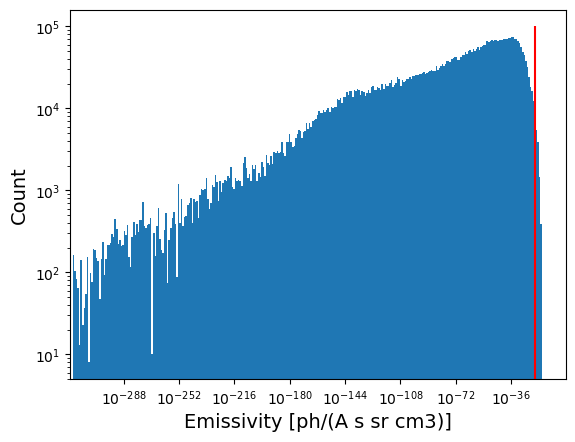

In [125]:
plt.figure(dpi=100)
bins = np.logspace(-324,-16,308)

res = plt.hist(emissivity_cylinder.value, bins=bins)
# plt.xlim([1e-300, 1e-10])
plt.vlines(np.mean(emissivity_cylinder[filter_test]).value, 0,1e5, color="red")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
plt.savefig("../visuals/emissivity_histogram.png")

plt.show()

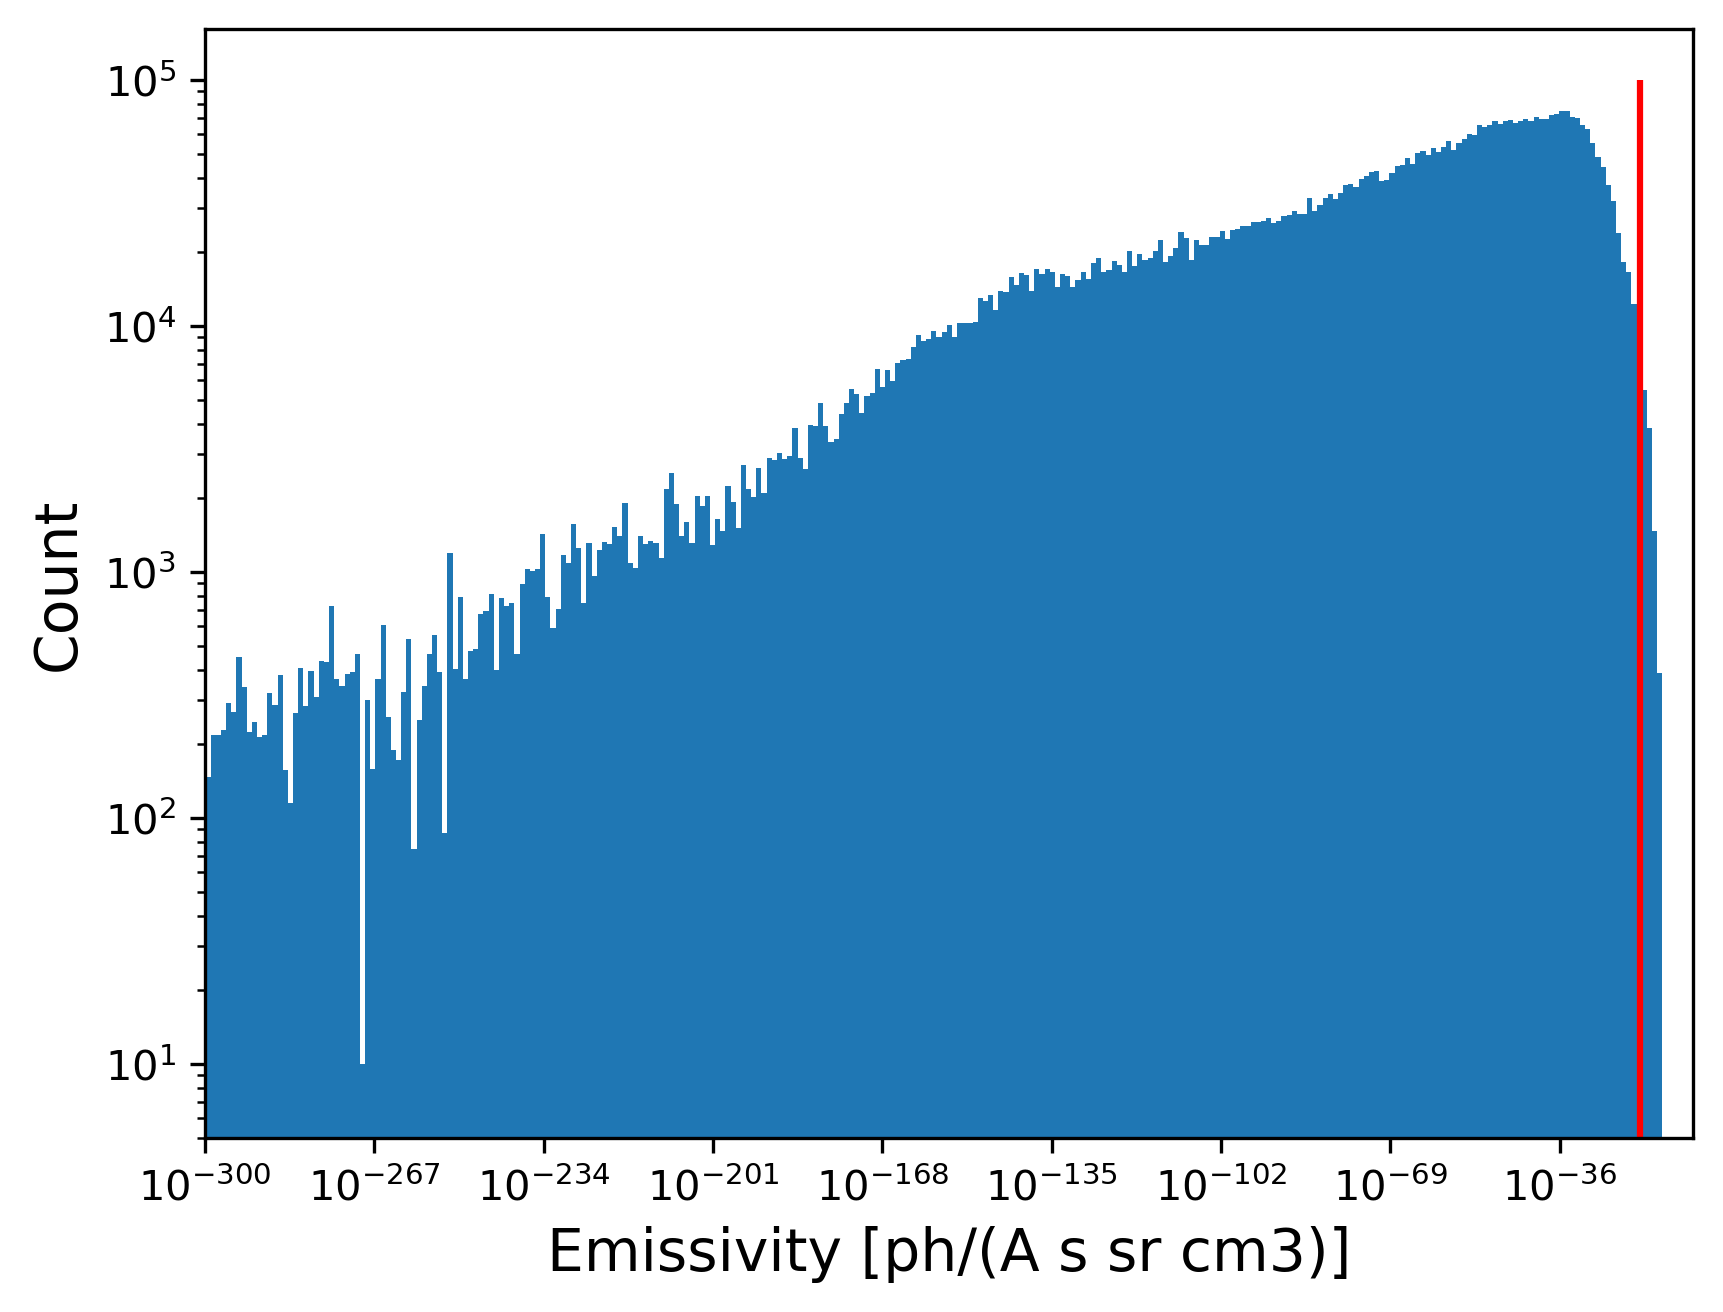

In [120]:
plt.figure(dpi=300)
# bins = np.logspace(-324,-10,314)
bins = np.logspace(-324,-16,308)

filter_test = (emissivity_cylinder.value < 1e-27) #& (emissivity_cylinder.value > 1e-48)
filter_test = emissivity_cylinder.value == emissivity_cylinder.value

res = plt.hist(emissivity_cylinder.value[filter_test], bins=bins)
plt.xlim([1e-300, 1e-10])
# plt.xlim([])
plt.vlines(np.mean(emissivity_cylinder[filter_test]).value, 0,1e5, color="red")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
# plt.xlabel("Temp [eV]", size=14)
plt.savefig("../visuals/emissivity_histogram.png")

plt.show()

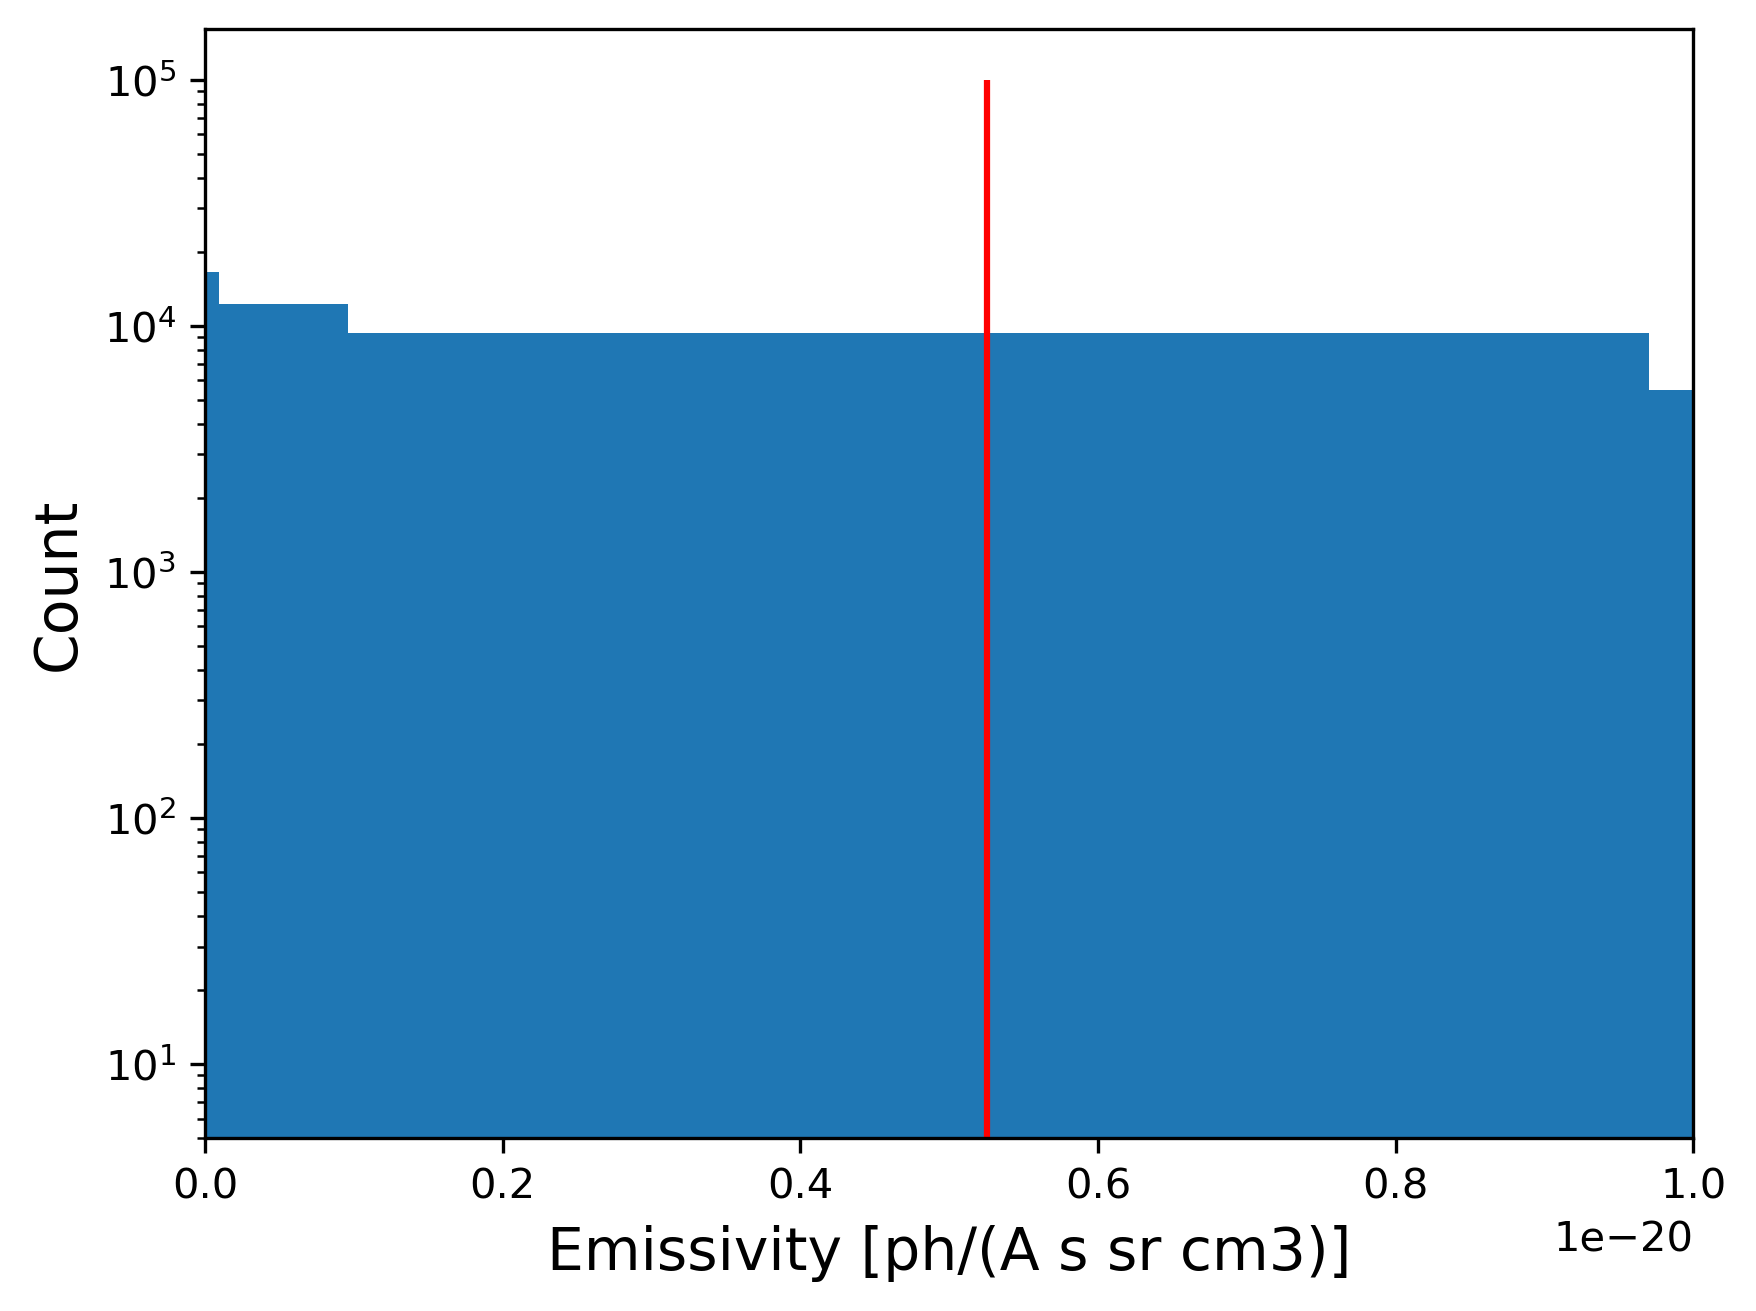

In [82]:
plt.figure(dpi=300)
# bins = np.logspace(-324,-10,314)
bins = np.logspace(-324,-16,308)

filter_test = (emissivity_cylinder.value < 1e-27) #& (emissivity_cylinder.value > 1e-48)
filter_test = emissivity_cylinder.value == emissivity_cylinder.value
res = plt.hist(emissivity_cylinder.value[filter_test], bins=bins)
plt.xlim([1e-300, 1e-20])
# plt.xlim([])
plt.vlines(np.mean(emissivity_cylinder[filter_test]).value, 0,1e5, color="red")
plt.yscale("log")
# plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
# plt.xlabel("Temp [eV]", size=14)
plt.savefig("../visuals/emissivity_histogram.png")

plt.show()

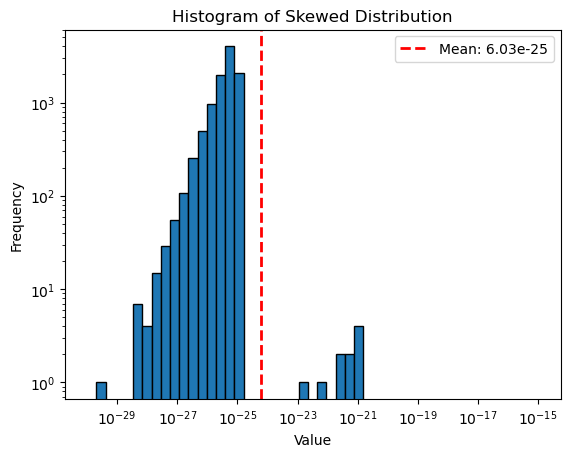

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a large number of small values and a few large values
small_values = np.random.uniform(1e-30, 1e-25, 10000)
large_values = np.random.uniform(1e-23, 1e-21, 10)

# Combine the values
data = np.concatenate((small_values, large_values))
# data = small_values
# Calculate mean
mean_value = np.mean(data)
bins = np.logspace(-30,-15,50)

# Plot the histogram
plt.hist(data, bins=bins, edgecolor='black', log=True)
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2e}')
plt.title('Histogram of Skewed Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xscale('log')
plt.legend()
plt.show()


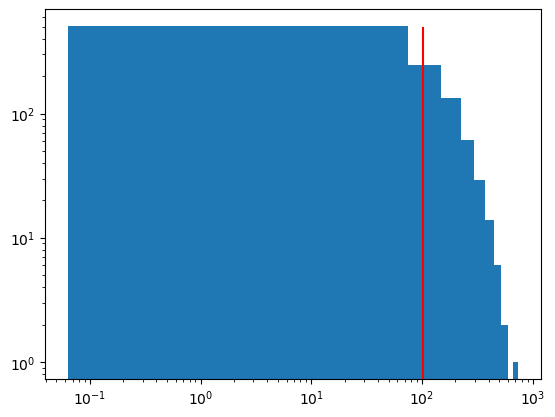

In [21]:
x = np.random.exponential(100, 1000)
plt.hist(x)
plt.vlines(np.mean(x), 0,500, color="red")
plt.xscale("log")
plt.yscale("log")


array([0.40056594, 0.04289747, 0.13702782, 0.6876144 , 0.15954774,
       0.40272527, 0.60844658, 0.24248154, 0.02017033, 0.59955475,
       0.04504127, 0.41024325, 0.83586377, 0.5622598 , 0.50110473,
       0.41395586, 0.95978864, 0.13677387, 0.40422272, 0.73142596,
       0.07451688, 0.41683004, 0.0466133 , 0.66785115, 0.83993158,
       0.45583369, 0.60981448, 0.87934867, 0.76694784, 0.00117092,
       0.16451811, 0.05300023, 0.66731712, 0.21833686, 0.3212815 ,
       0.76290178, 0.17392168, 0.94900048, 0.15003226, 0.06978129,
       0.52250439, 0.91393353, 0.07797181, 0.26440147, 0.9551679 ,
       0.35610848, 0.90919038, 0.32044308, 0.27289019, 0.50743273,
       0.87755536, 0.96632447, 0.84115005, 0.33083051, 0.30460017,
       0.74865757, 0.40698917, 0.35269864, 0.76750109, 0.9672505 ,
       0.78609606, 0.00636696, 0.90430225, 0.25884787, 0.10376318,
       0.63977677, 0.2295342 , 0.84779227, 0.97463173, 0.30565976,
       0.27521423, 0.57017997, 0.15292234, 0.44054603, 0.66249

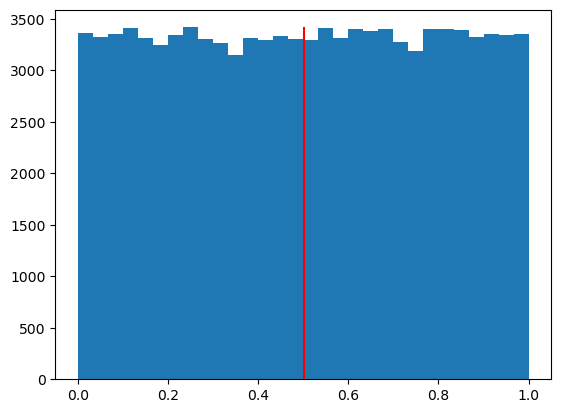

In [88]:
x_list = []
for i in range(100000):
    x = np.random.rand()
    y = np.random.rand()
    if y < 10**x:
        x_list.append(x)

x = np.linspace(0,1,1000)
y = 10**x
# plt.figure(dpi=300)
res = plt.hist(x_list, bins=30)
plt.vlines(np.mean(x_list), 0,np.max(res[0]), color="red")
# plt.plot(x,y * np.max(res[0]))
# plt.xscale("log")
# plt.yscale("log")


In [97]:
res

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 1.00000002,  1.04811316,  1.09854117,  1.15139542,  1.20679267,
         1.26485524,  1.32571139,  1.38949552,  1.45634851,  1.526418  ,
         1.59985875,  1.67683297,  1.75751066,  1.84207   ,  1.93069776,
         2.02358968,  2.12095092,  2.22299652,  2.32995184,  2.44205313,
         2.55954796,  2.68269583,  2.81176873,  2.94705174,  3.08884363,
         3.23745758,  3.39322181,  3.55648034,  3.72759376,  3.90693997,
         4.0949151 ,  4.2919343 ,  4.4984327 ,  4.7148664 ,  4.9417134 ,
         5.17947471,  5.42867547,  5.68986606,  5.96362335,  6.25055195,
         6.5512856 ,  6.86648848,  7.19685675,  7.54312008,  7.90604323,
         8.28642774,  8.68511375,  9.10298179,  9.54095477, 10.        ]),
 <BarContainer object of 49 artists>)

In [98]:
bins

array([ 1.00000002,  1.04811316,  1.09854117,  1.15139542,  1.20679267,
        1.26485524,  1.32571139,  1.38949552,  1.45634851,  1.526418  ,
        1.59985875,  1.67683297,  1.75751066,  1.84207   ,  1.93069776,
        2.02358968,  2.12095092,  2.22299652,  2.32995184,  2.44205313,
        2.55954796,  2.68269583,  2.81176873,  2.94705174,  3.08884363,
        3.23745758,  3.39322181,  3.55648034,  3.72759376,  3.90693997,
        4.0949151 ,  4.2919343 ,  4.4984327 ,  4.7148664 ,  4.9417134 ,
        5.17947471,  5.42867547,  5.68986606,  5.96362335,  6.25055195,
        6.5512856 ,  6.86648848,  7.19685675,  7.54312008,  7.90604323,
        8.28642774,  8.68511375,  9.10298179,  9.54095477, 10.        ])

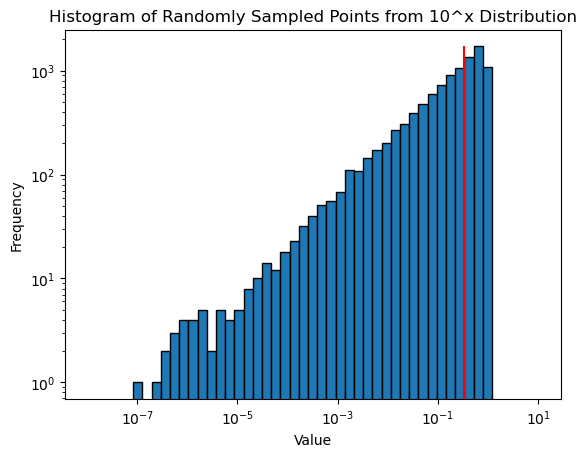

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples
num_samples = 10000

# Generate random samples from a uniform distribution in the range [0, 1)
uniform_samples = np.random.rand(num_samples)

bins = np.logspace(-8,1,50)
# bins=50
# Transform the samples to the desired distribution 10^x
distribution_samples = 10 ** uniform_samples
distribution_samples = uniform_samples**2
# Plot the histogram
res = plt.hist(distribution_samples, bins=bins, edgecolor='black')
plt.title('Histogram of Randomly Sampled Points from 10^x Distribution')
plt.vlines(np.mean(distribution_samples), 0,np.max(res[0]), color="red")

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for better visualization
plt.xscale('log')  # Use log scale for better visualization

plt.show()


(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

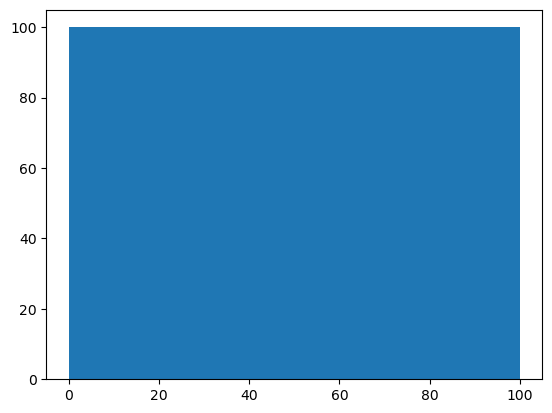

In [12]:
x = np.linspace(0,100,1000)

for i in range(1000):
    x = np.random.rand()
    if x < x**2:
        

plt.hist(x)

In [220]:
np.mean(emissivity_cylinder.value[emissivity_cylinder.value!=0])

5.259639443206615e-21

In [222]:
emissivity_cylinder.shape[0]

4900976

In [223]:
np.sum(emissivity_cylinder) / emissivity_cylinder.shape[0]  #* (600 * u.pc).to(u.cm)

<Quantity 5.25200375e-21 ph / (Angstrom s sr cm3)>

In [202]:
hist, edges = np.histogram(emissivity_cylinder.value, bins = bins)


In [207]:
np.mean(emissivity_cylinder)

<Quantity 5.25200375e-21 ph / (Angstrom s sr cm3)>

In [200]:
import scipy
scipy.stats.mode(emissivity_cylinder)

ModeResult(mode=0.0, count=7115)

2.5873529001186704 eV 13439.365093048658 eV


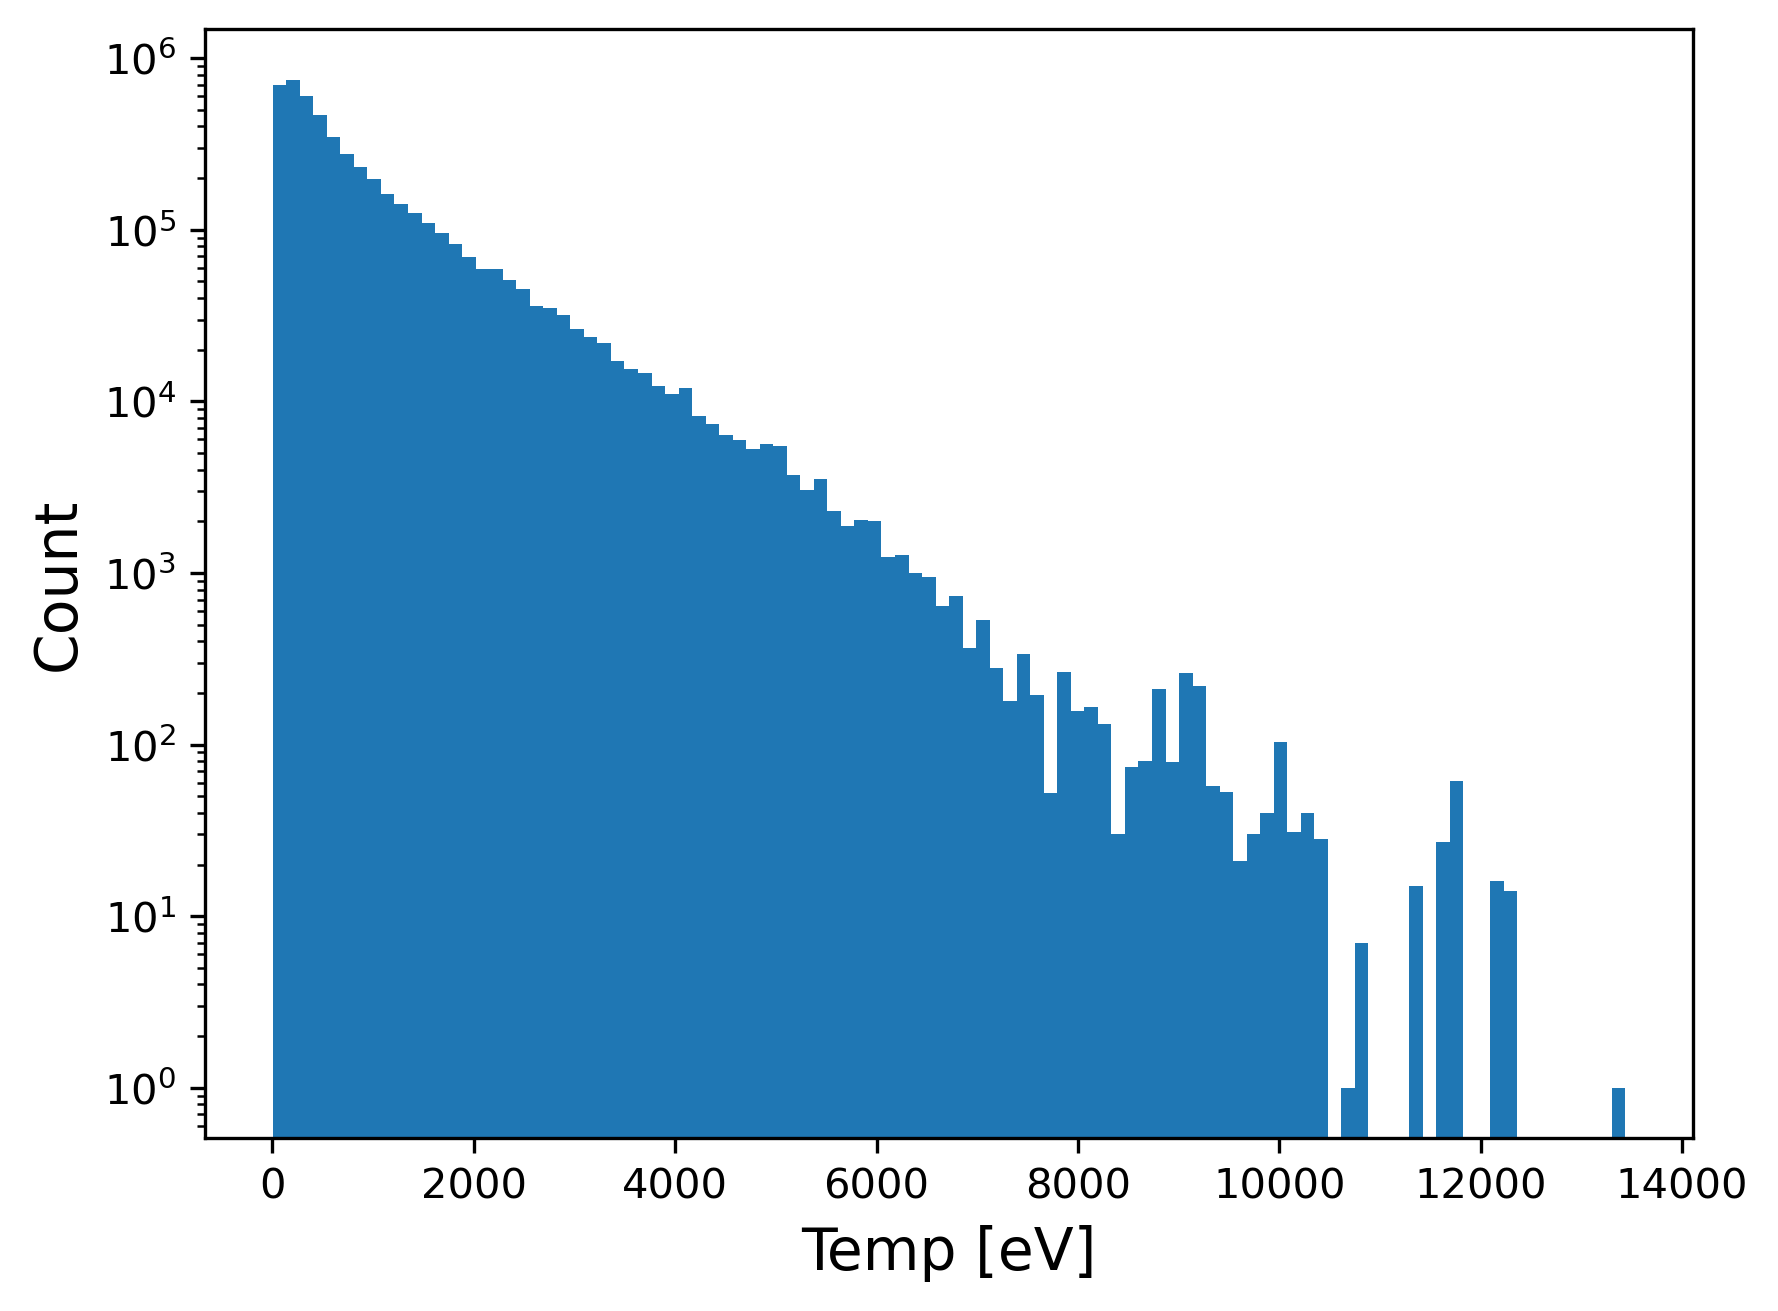

In [175]:
print(np.min(emissivity_cylinder[emissivity_cylinder!=0]), np.max(emissivity_cylinder))
plt.figure(dpi=300)
# bins = np.logspace(-324,-10,314)
res = plt.hist(emissivity_cylinder.value, bins=100)
# plt.xlim([1e-28, 1e-10])
# plt.xlim([])
plt.yscale("log")
# plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
plt.xlabel("Temp [eV]", size=14)
plt.savefig("../visuals/emissivity_histogram.png")
plt.show()

In [172]:
cube_dv

array([[[149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732956, 247641.26732956],
        [149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732956, 247641.26732956],
        [149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732956, 247641.26732956],
        ...,
        [ 84527.96509   ,  84527.96509   ,  84527.96509   , ...,
         102077.75151772, 103512.07037661, 103512.07037661],
        [ 84527.96509   ,  84527.96509   ,  84527.96509   , ...,
         123897.41474999, 123897.41474999, 122463.09589109],
        [ 84527.96509   ,  84527.96509   ,  84527.96509   , ...,
         123897.41474999, 123897.41474999, 123897.41474999]],

       [[149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732956, 247641.26732956],
        [149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732

In [173]:
cube_eff = cube * K_to_eV + 1/2 * (938 * u.MeV).to(u.eV) * (cube_dv/cst.c.value)**2

<Quantity 9.72359414 ph / (Angstrom s sr cm2)>

# Define simulation resolution

In [110]:
NSIDE = 2**5
NPIX = hp.nside2npix(NSIDE)
dOmega = hp.nside2pixarea(nside=NSIDE)

# Sample from histogram to generate skymap

In [125]:
hist = res[0]

bin_midpoints = (bins[:-1] + bins[1:])/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]

values = np.random.rand(NPIX)
value_bins = np.searchsorted(cdf, values)
sampled_emissivity = bin_midpoints[value_bins] * emissivity_cylinder.unit

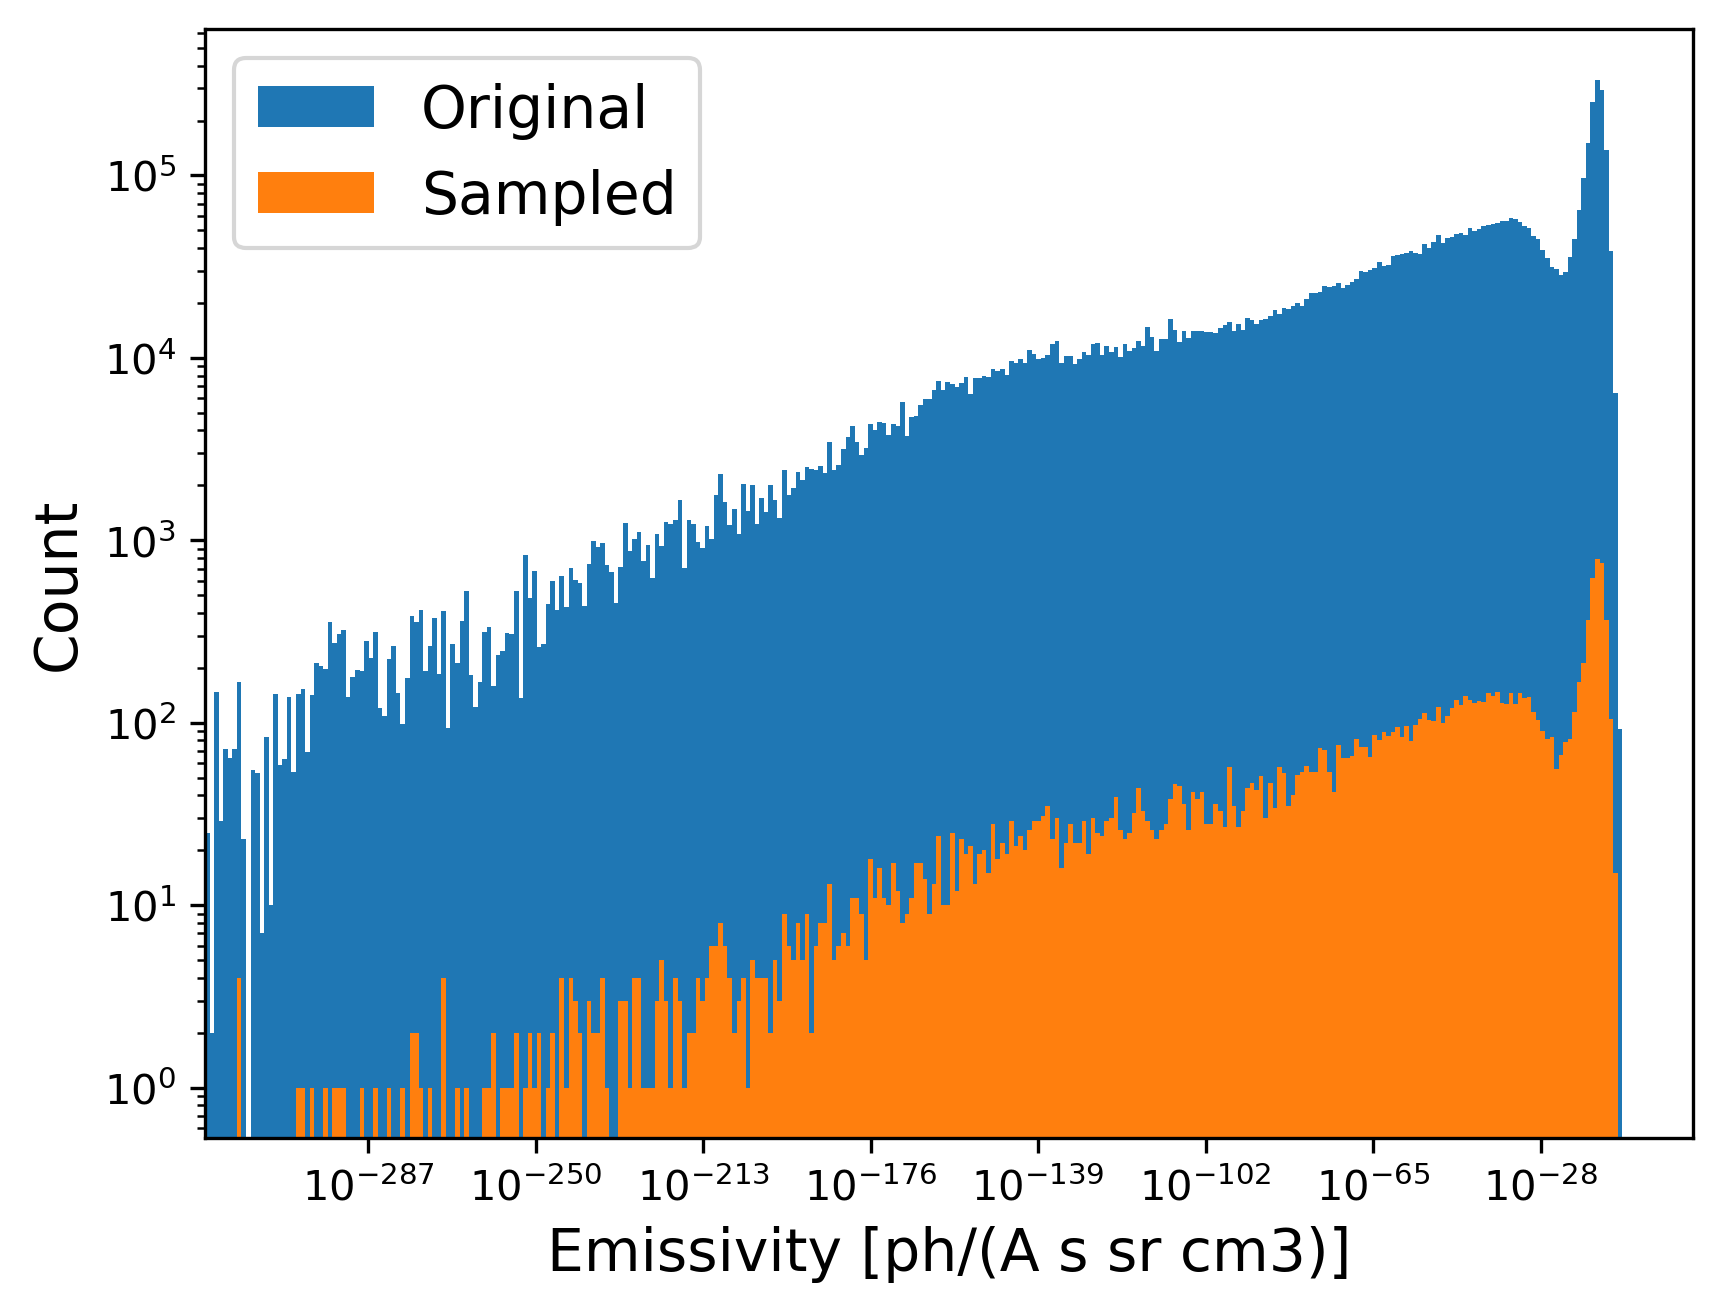

In [127]:
plt.figure(dpi=300)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
plt.hist(emissivity_cylinder.value, bins=bins, label="Original")
plt.hist(sampled_emissivity.value,  bins=bins, label="Sampled")
plt.legend(fontsize=14)
plt.savefig("../visuals/emissivity_histogram_sampled.png")
plt.show()

# Integrate

In [134]:
sampled_emissivity *= (600 * u.pc).to(u.cm)
(600 * u.pc).to(u.cm)

<Quantity 1.85140655e+21 cm>

# Plot skymap of results

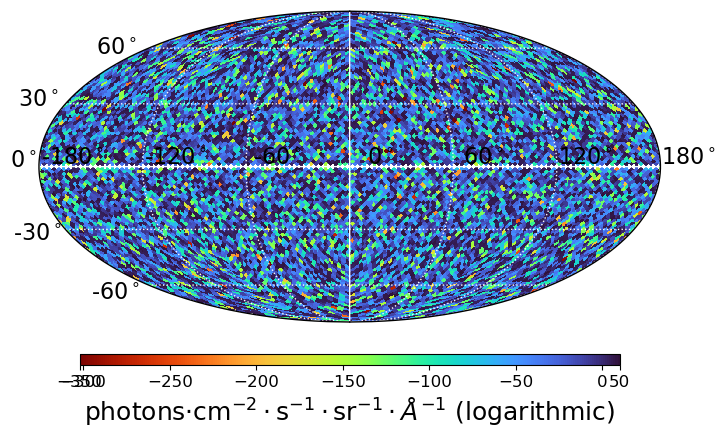

In [133]:
def create_skymap2(signal, signal_unit):
    
    theta, phi = hp.pix2ang(NSIDE, np.arange(len(signal)))
    # Convert theta to latitude in degrees
    latitude = np.degrees(np.pi / 2 - theta)
    
    # Create a mask for latitudes between -27 and 27 degrees
    # mask = (latitude >= -25) & (latitude <= 25)
    mask = (latitude >= 0) & (latitude <= 0)
    
    # Mask the data
    signal_plot = signal.copy()
    signal_plot[mask] = np.nan

    signal_plot = np.log10(signal_plot.value)
    min_value = np.nanmin(signal_plot)
    max_value = np.nanmax(signal_plot)
    
    f1 = plt.figure(figsize=(7.5,4.5), dpi=100)

    hp.mollview(signal_plot, 
                title="", 
                rot=(0,0,0),
                cmap='turbo_r', 
                fig=f1, 
                unit="",
                min = min_value,#min_value.value,#1,#np.min(f_aqn[f_aqn!=-1*f_aqn.unit]).value,
                max = max_value,#np.nanmax(signal).value,
                badcolor="white", cbar=False)
    #hp.graticule(dmer=360,dpar=360,alpha=0)  
    hp.graticule(dmer=60,dpar=30, alpha=1, color="white", linewidth=10)
    longitude_labels = [-180,-120,-60,0,60,120,180]
    label_size = 16
    for i in range(len(longitude_labels)):
        plt.text((-2.7+i)*0.66,0.02,str(longitude_labels[i])+"$^\circ$",size=16,horizontalalignment="center")

    latitude_labels = [-90,-60,-30,0,30,60,90]
    plt.text(-2.01,-0.47,"-30$^\circ$",size=label_size,horizontalalignment="center") 
    plt.text(-2.1,0,"0$^\circ$",size=label_size,horizontalalignment="center")
    plt.text(-2,0.39,"30$^\circ$",size=label_size,horizontalalignment="center") 
    plt.text(-1.5,0.73,"60$^\circ$",size=label_size,horizontalalignment="center") 
    plt.text(-1.51,-0.85,"-60$^\circ$",size=label_size,horizontalalignment="center") 


    # Customize the colorbar
    fig = plt.gcf()
    ax = fig.axes[0]  # Get the axis of the mollview plot
    im = ax.get_images()[0]
    
    # Add a new colorbar
    cbar = fig.colorbar(im, orientation='horizontal', pad=0.075, aspect=50, shrink=0.75)
    cbar.set_label(r'photons$\cdot$cm$^{-2}\cdot$s$^{-1}\cdot$sr$^{-1}\cdot\AA^{-1}$ (logarithmic)', size=18)

    
    # Adjust the size of the colorbar
    cbar.ax.tick_params(labelsize=12)  # Adjust tick size
    # cbar.ax.set_xlabel('Unit', size=16) 
    # plt.savefig("simulated_signal_sky_map.png", bbox_inches = "tight")
    plt.savefig("skymap_2.png", bbox_inches = "tight")

    # plt.savefig("simulated_signal_sky_map.pdf", bbox_inches = "tight")

    plt.show()

create_skymap2(sampled_emissivity, sampled_emissivity.unit)

In [87]:
print(f_aqn)

[19.04437218 19.04437218 19.04437218 ... 19.04437218 19.04437218
 19.04437218] ph / (Angstrom s sr cm2)


In [83]:
print(f_aqn)

[4.14328156 4.14328156 4.14328156 ... 4.14328156 4.14328156 4.14328156] ph / (Angstrom s sr cm2)
